In [184]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (12.0, 8.0)
import seaborn

data_url = "https://docs.google.com/spreadsheets/d/1r9_uz-QcvisvqR9CEy0s8-qRk_Dc5EAELxf5hHtvKDs/export?format=xlsx"

## Step 1: Measure the slit widths and estimate the error

In [185]:
widths = pd.read_excel(data_url, sheetname="Slit Widths", header=(0,1), skiprows=None)
#take the mean exluding the first two columns
widths['mean'] = widths[[2,3,4,5]].mean(axis=1)
widths['std'] = widths[[2,3,4,5]].std(axis=1)
widths["% error"] = 100 * widths['std'] / widths['mean']
widths

Slit Number Measured By Taki using transmitted light          \
S_n                                              Top  Bottom   
1                                             0.4960  0.4974   
2                                             0.1971  0.1954   
3                                             0.0988  0.1015   
4                                             0.0484  0.0509   
5                                             0.0256  0.0234   

Slit Number Measured By Tom using transmitted light          \
S_n                                             Top  Bottom   
1                                            0.5009  0.5003   
2                                            0.2010  0.1991   
3                                            0.1016  0.0976   
4                                            0.0520  0.0510   
5                                            0.0262  0.0250   

Slit Number Measured By Tom using reflected light              mean       std  \
S_n                                           Top  Bottom                       
1                                          0.5002  0.4991  0.500125  0.000750   
2                                          0.1996  0.1990  0.199675  0.000922   
3                                          0.0995  0.1001  0.099700  0.001655   
4                                          0.0466  0.0497  0.049825  0.002347   
5                                          0.0241  0.0259  0.025300  0.000949   

Slit Number   % error  
S_n                    
1            0.149963  
2            0.461501  
3            1.660275  
4            4.710811  
5            3.749736

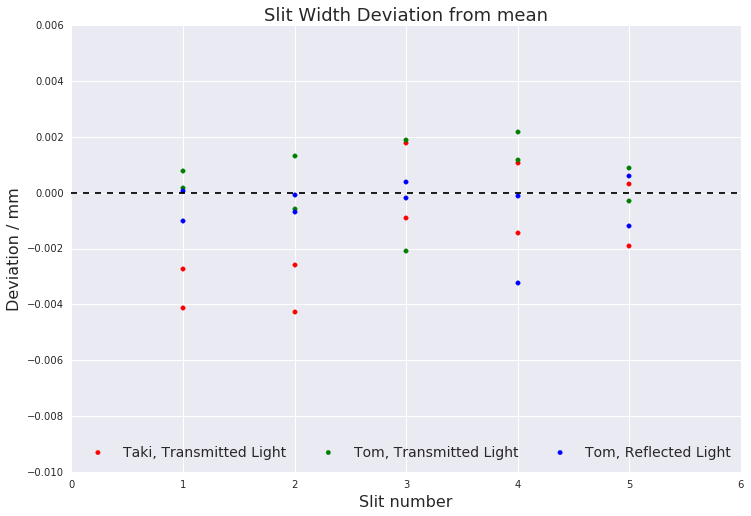

In [186]:
#plot the deviations in slit width measurements
ys =[ widths[column_name] - widths["mean"] for column_name in widths[[0,1,2,3,4,5]]]
x = np.arange(1,6)

taki_t = plt.scatter(x, ys[0], marker='o', color = "r")
taki_b = plt.scatter(x, ys[1], marker='o', color = "r")

tom_t = plt.scatter(x, ys[2], marker='o', color = "g")
tom_b = plt.scatter(x, ys[3], marker='o', color = "g")

tom_t_r = plt.scatter(x, ys[4], marker='o', color = "b")
tom_b_r = plt.scatter(x, ys[5], marker='o', color = "b")


plt.legend((taki_t, tom_t, tom_t_r),
           ('Taki, Transmitted Light',
            'Tom, Transmitted Light',
            'Tom, Reflected Light'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=14)

#true value
plt.plot((0, 6), (0, 0), "k--")
plt.title("Slit Width Deviation from mean", fontsize=18)
plt.xlim((0,6))
plt.gca().set_ylabel('Deviation / mm', fontsize=16)
plt.gca().set_xlabel('Slit number', fontsize=16)
#plt.annotate("We removed these four points from\nthe mean as outliers", (1, -0.006), fontsize = 14)
plt.savefig("./figs/Slit_deviations.png", dpi = 300)

## Step 2: Estimate the error in the minima position measurement
#### Normally we only marked the two highest orders we could see, but for one masurement we made everyone mark all the orders

In [187]:
minima = pd.read_excel(data_url, sheetname="Minima position ", header=(0,1), skiprows=(), index_col = 0)
minima.index.name = "Order"
minima.T

Order                           10    9     8     7     6     5     4     3   \
Minima position (mm) Tom      65.5  59.5  52.5  46.5  39.5  33.0  26.0  20.0   
                     Lauren   65.0  59.5  52.5  46.0  40.0  33.5  26.5  20.0   
                     William  65.5  59.5  52.0  46.0  39.0  33.0  26.0  19.5   
                     Henry    66.0  59.0  52.0  45.5  39.0  33.0  25.0  20.0   

Order                           2    1   ...   -1   -2   -3    -4    -5   \
Minima position (mm) Tom      13.5  7.0  ...  -6.0  -13  -20 -26.5 -33.0   
                     Lauren   14.0  6.0  ...  -6.0  -13  -19 -26.0 -32.5   
                     William  13.0  6.5  ...  -6.5  -14  -20 -28.0 -33.0   
                     Henry    13.0  7.0  ...  -6.5  -13  -20 -26.6 -32.5   

Order                          -6    -7    -8    -9    -10  
Minima position (mm) Tom     -39.0 -45.5 -52.0 -58.5 -65.5  
                     Lauren  -39.0 -45.5 -52.0 -59.0 -66.0  
                     William -39.5 -46.5 -52.5 -60.0 -66.0  
                     Henry   -38.5 -45.0 -51.0 -58.5 -65.0  

[4 rows x 21 columns]

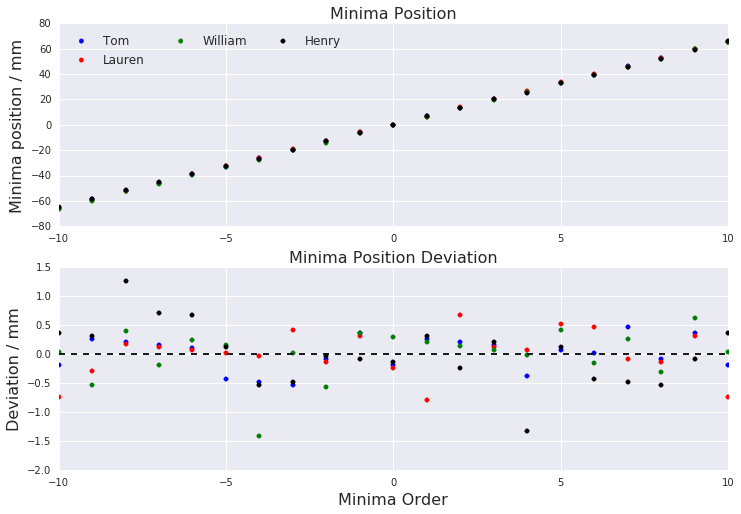

In [188]:
names = [("Tom",'b'),("Lauren", "r"), ("William", 'g'), ("Henry", "k")]
lines = []
f, (ax2, ax1) = plt.subplots(2,1)
deviations = pd.DataFrame()

for name,col in names:
    #fit a straight line to each
    d,C = np.polyfit(minima.index, minima["Minima position (mm)"][name], deg = 1)
    #print("{}: d from curve fit: \t{:.4}mm".format(name, d))

    ax2.scatter(minima.index, minima["Minima position (mm)"][name], color = col)
    d_est = (minima["Minima position (mm)"][name].iloc[0] - minima["Minima position (mm)"][name].iloc[-1]) / 20
    #print("{}: dist / n: \t\t{:.4}mm\n".format(name,  d_est))
    
    deviations[name] = minima["Minima position (mm)"][name] - (d_est*minima.index + C)
    #plot deviations from (max - min) / n
    lines.append( ax1.scatter(minima.index, deviations[name], color = col) )
    
ax2.legend(lines,
            [n for n,c in names],
           scatterpoints=1,
           loc='upper left',
           ncol=3,
           fontsize=12)

ax1.plot((-10, 10), (0, 0), "k--")
ax1.set_title("Minima Position Deviation", fontsize = 16)
ax2.set_title("Minima Position", fontsize = 16)
ax1.set_xlim((-10,10))
ax2.set_xlim((-10,10))
ax1.set_ylabel('Deviation / mm', fontsize = 16)
ax2.set_ylabel('Minima position / mm', fontsize = 16)
ax1.set_xlabel('Minima Order', fontsize = 16)
plt.savefig("./figs/Minima_deviations.png", dpi = 300)  

In [189]:
deviations.std()

Tom        0.296909
Lauren     0.402152
William    0.441133
Henry      0.556530
dtype: float64

From this we can use a conserative estimate for the error in a meausuremt of a minima position as 0.6mm, so the error in our estimate of the minima separation is $$\frac{\sqrt{0.6^2 + 0.6^2}}{n} $$ where n is the number of minima

In [190]:
from math import sqrt
sqrt(0.6**2 + 0.6**2)

0.848528137423857

This agrees with the error we estimated by eye for this slit

## Step 3: fit the model to the data in light of these errors 

In [191]:
day_1 = pd.read_excel(data_url, sheetname="Single slit day 1", header=(1), skiprows=0)
day_2 = pd.read_excel(data_url, sheetname="Single slit day 2", header=(1), skiprows=0)
day_1.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
S_n,1.00000,2.00000,3.00000,4.00000,1.00000,2.00000,3.00000,4.00000,5.00000,1.00000,2.00000,3.00000,4.00000,5.00000
y,182.00000,162.00000,193.00000,129.00000,200.00000,176.00000,175.00000,116.00000,122.00000,210.00000,184.00000,185.00000,124.00000,123.00000
delta_y,1.00000,2.00000,3.00000,5.00000,1.00000,2.00000,4.00000,5.00000,17.00000,2.00000,2.00000,4.00000,10.00000,10.00000
n,29.00000,11.00000,7.00000,3.00000,35.00000,13.00000,7.00000,3.00000,2.00000,35.00000,13.00000,7.00000,3.00000,2.00000
D_h,5.16277,5.16277,5.16277,5.16277,4.66277,4.66277,4.66277,4.66277,4.66277,4.91277,4.91277,4.91277,4.91277,4.91277
D_v,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000,0.03000
delta_D_h,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500


In [192]:
#reformat the datasets a bit
#put everything in meters
def reformat(data):
    #look up the measured d value corresponding to each slit
    if "d" not in data:
        data.insert(0, "d", 1e-3 * np.array(widths['mean'][data.S_n]))
        data.insert(0, "delta_d_", 1e-3 * np.array(widths['std'][data.S_n]))
        
    if "S_n" in data: data = data.drop("S_n", axis = 1)
    
    #convert y to meters and divide by n -1
    if "n" in data:
        data.y = 1e-3 * data.y / (data.n - 1)
        data.delta_y = 1e-3 * data.delta_y / (data.n - 1)
        data = data.drop("n", axis = 1)
        
    #apply the horizontal correction and get rid of the extra columns
    if "D_h" in data:
        data["D"] = np.sqrt(data.D_h**2 + data.D_v**2)
        data["delta_D"] = data.delta_D_h
        data = data.drop(["D_h", "D_v", "delta_D_h"], axis = 1)
        
    
    return data

day_1 = reformat(day_1)
day_2 = reformat(day_2)
both = pd.concat([day_1,day_2])
both.T

,0,1,2,3,4,5,6,7,8,9,...,6,7,8,9,10,11,12,13,14,15
D,5.162857e+00,5.162857e+00,5.162857,5.162857,4.662867e+00,4.662867e+00,4.662867,4.662867,4.662867e+00,4.912862e+00,...,5.311285,5.311285,4.811294e+00,4.811294e+00,4.811294,4.811294,5.011290e+00,5.011290e+00,5.011290,5.011290
d,5.001250e-04,1.996750e-04,0.000100,0.000050,5.001250e-04,1.996750e-04,0.000100,0.000050,2.530000e-05,5.001250e-04,...,0.000100,0.000050,5.001250e-04,1.996750e-04,0.000100,0.000050,5.001250e-04,1.996750e-04,0.000100,0.000050
delta_D,5.000000e-03,5.000000e-03,0.005000,0.005000,5.000000e-03,5.000000e-03,0.005000,0.005000,5.000000e-03,5.000000e-03,...,0.005000,0.005000,5.000000e-03,5.000000e-03,0.005000,0.005000,5.000000e-03,5.000000e-03,0.005000,0.005000
delta_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000001,0.000001,7.000000e-07,8.500000e-07,0.000001,0.000001,7.000000e-07,8.500000e-07,0.000001,0.000001
delta_d_,7.500000e-07,9.215024e-07,0.000002,0.000002,7.500000e-07,9.215024e-07,0.000002,0.000002,9.486833e-07,7.500000e-07,...,0.000002,0.000002,7.500000e-07,9.215024e-07,0.000002,0.000002,7.500000e-07,9.215024e-07,0.000002,0.000002
delta_y,3.571429e-05,2.000000e-04,0.000500,0.002500,2.941176e-05,1.666667e-04,0.000667,0.002500,1.700000e-02,5.882353e-05,...,0.000667,0.002500,8.333333e-05,2.500000e-04,0.000667,0.001500,2.702703e-05,2.142857e-04,0.000333,0.002500
y,6.500000e-03,1.620000e-02,0.032167,0.064500,5.882353e-03,1.466667e-02,0.029167,0.058000,1.220000e-01,6.176471e-03,...,0.033667,0.067000,6.250000e-03,1.516667e-02,0.030500,0.060500,6.297297e-03,1.578571e-02,0.031667,0.062500


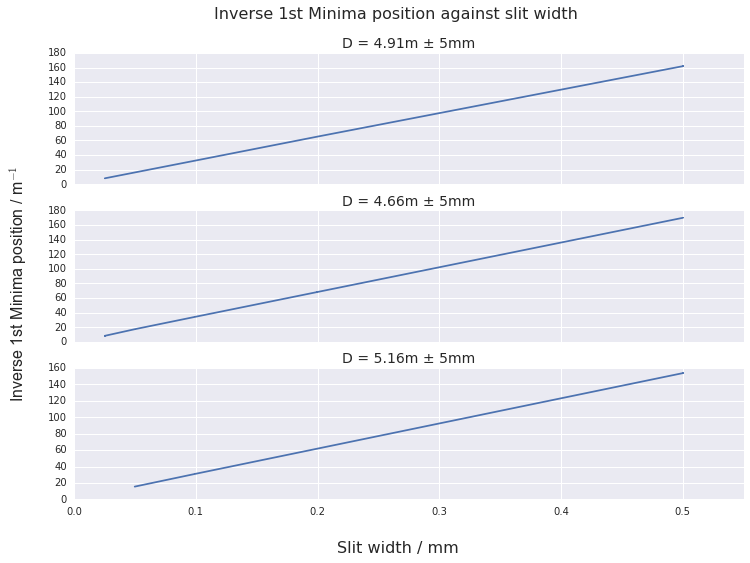

In [193]:
def plot_single_slit(data, subtitle = ""):
    #split the data by the D value
    gb = data.groupby(by = ["D"])
    
    #make space for a plot for each D value
    f, axes = plt.subplots(len(gb), sharex='col')

    # Set common labels
    f.text(0.5, 0.04, 'Slit width / mm', ha='center', va='center', fontsize = 16)
    f.text(0.06, 0.5, 'Inverse 1st Minima position / m$^{-1}$', ha='center', va='center', rotation='vertical', fontsize = 16)

    f.suptitle("Inverse 1st Minima position against slit width {}".format(subtitle), fontsize=16)

    #loop over the subsets of the data and plot
    for label, ax in zip(gb.groups, axes):
        ax.set_xlim(0, 0.55)
        ex = gb.get_group(label)
        
        #plot inverse y against d
        inv_y = 1 / ex.y
        d_inv_y = ex.delta_y  / ex.y**2

        ax.errorbar(1e3 * ex.d, inv_y, yerr = d_inv_y.as_matrix())
        ax.set_title("D = {:.3}m ± 5mm".format(label), fontsize = 14)

plot_single_slit(day_1)
plt.savefig("./figs/Results_1.png", dpi = 300)

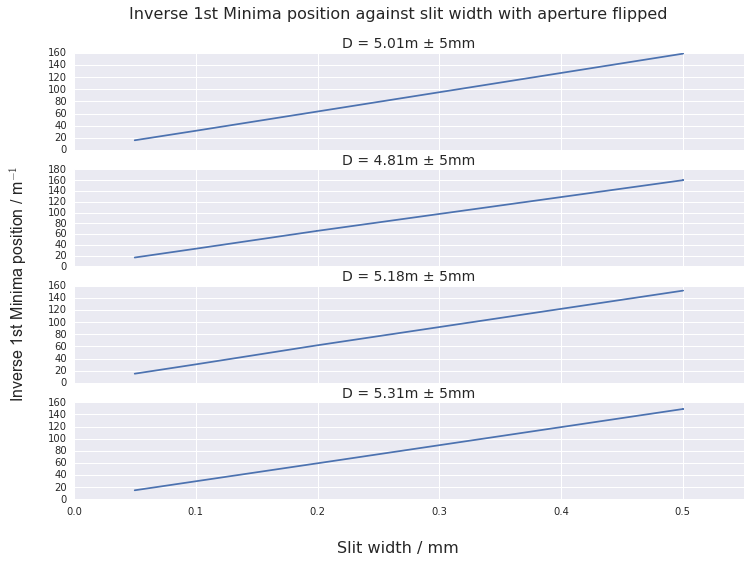

In [194]:
plot_single_slit(day_2, subtitle = "with aperture flipped")
plt.savefig("./figs/Results_2.png", dpi = 300)

We want to fit a function of the form:
$$ y = \lambda \frac{D}{d} $$

In [195]:
true_l = 632.8e-9

#results from day 1
from scipy.optimize import curve_fit

def fn(x, l):
    D, d = x
    return l*x.D / x.d


def fit(data, p0 = true_l):
    popt, pcov = curve_fit(fn, data[["D", "d"]], data["y"], p0 = p0, sigma = data.delta_y, absolute_sigma = True)
    l = popt[0]
    sigma = np.sqrt(pcov[0])[0]
    return l, sigma

l1, delta_l1 = fit(day_1)
l2, delta_l2 = fit(day_2)
l4, delta_l4 = fit(both)

print("lambda from day 1 = {:.4}nm ± {:.2}nm".format(l1 * 1e9, delta_l1  * 1e9))
print("lambda from day 2 = {:.4}nm ± {:.2}nm".format(l2  * 1e9, delta_l2  * 1e9))
print("lambda from both = {:.4}nm ± {:.2}nm".format(l4  * 1e9, delta_l4  * 1e9))

### results from the paper we found ###
def external_lambda():
    g = 0.601 * 1e6 #m^-1
    delta_g = 0.003 * 1e6 #m^-1
    L = 2.653 #m
    l = 1 / (g * L)
    delta_l = delta_g / (L * g)**2
    return l, delta_l

l3, delta_l3 = external_lambda()
print("External lambda = {:.4}nm ± {:.2}nm".format(l3  * 1e9, delta_l3  * 1e9))


lambda from day 1 = 628.7nm ± 1.8nm
lambda from day 2 = 630.9nm ± 1.7nm
lambda from both = 629.9nm ± 1.2nm
External lambda = 627.2nm ± 1.2nm


The above regression doesn't take into account the errors in D so I'll try adding gaussian noise N(mean = 0, sigma) to the D values and runnning the regression many times, to estimate the error in the regression due to error in D

In [196]:
def noisy_fit(data, n = 1000):
    data["true_D"] = data.D
    data["true_d"] = data.d
    ls = []
    for i in range(n):
        data.D = data.true_D + np.random.normal(loc = 0.0, scale = 0.005, size = len(data.D))
        data.d = np.array([np.random.normal(mean, std) for mean,std in np.array(data[["true_d", "delta_d_"]])])
        #data.d = data.true_d + np.random.normal(loc = 0.0, scale = 0.000750, size = len(data.d))
        popt, pcov = curve_fit(fn, data[["D", "d"]], data["y"], p0 = true_l, sigma = data.delta_y, absolute_sigma = True)
        ls.append(popt[0])
        
    data.D = data.true_D
    data.d = data.true_d
    return np.array(ls)

ls = noisy_fit(day_1)

print("original fitted lambda: {:.4}nm".format(l1 * 1e9))
print("mean fitted lambda: {:.4}nm".format(ls.mean() * 1e9))
print("sigma due to errors in D and d: ±{:.3}nm, ±{:.2}%".format(ls.std() * 1e9, 100 * ls.std() / ls.mean()))
print("sigma due to errors in y: ±{:.3}nm, ±{:.2}%".format(delta_l1 * 1e9, 100 * delta_l1 / ls.mean()))

total = np.sqrt(delta_l1**2 + ls.std()**2)
err = ls.std()
print("Total: ±{:.3}nm".format( total * 1e9, 100 * total / ls.mean()))

original fitted lambda: 628.7nm
mean fitted lambda: 628.7nm
sigma due to errors in D and d: ±0.782nm, ±0.12%
sigma due to errors in y: ±1.84nm, ±0.29%
Total: ±2.0nm


Clearly the error in D makes very little difference

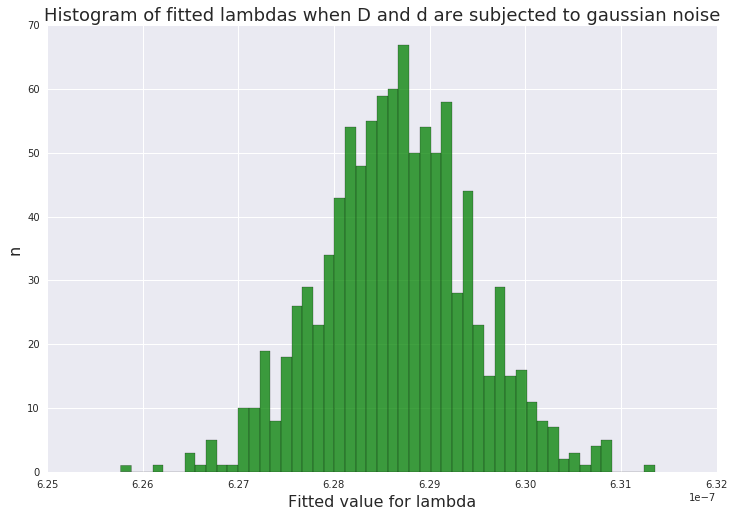

In [197]:
# the histogram of the data
n, bins, patches = plt.hist(ls, 50, facecolor='g', alpha=0.75)
plt.xlabel('Fitted value for lambda', fontsize = 16)
plt.ylabel('n', fontsize = 16)
plt.title('Histogram of fitted lambdas when D and d are subjected to gaussian noise', fontsize = 18)
plt.savefig("./figs/D_hist.png", dpi = 300)

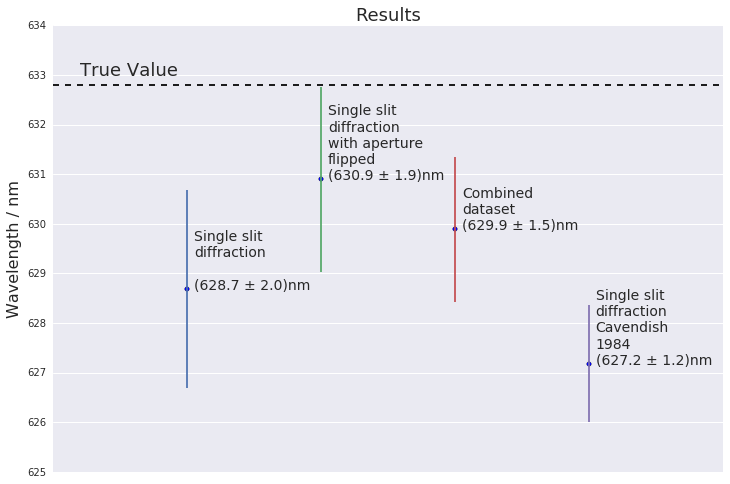

In [198]:
#collect the results together with some labels
ls = np.array([l1, l2, l4, l3]) * 1e9
#ls = np.array([l1]) * 1e9
delta_ls = np.array([np.sqrt(delta_l1**2 + err**2),
                     np.sqrt(delta_l2**2 + err**2),
                     np.sqrt(delta_l4**2 + err**2),
                     delta_l3]) * 1e9
labels = ('Single slit\ndiffraction\n',
          'Single slit\ndiffraction\nwith aperture\nflipped',
          'Combined\ndataset',
          'Single slit\ndiffraction\nCavendish\n1984')

for n, l, delta_l, label in zip(range(len(ls)), ls, delta_ls, labels):
    plt.scatter((n,), (l,))
    plt.errorbar((n,), (l,), yerr = (delta_l,))
    value = "\n({:.4} ± {:.2})nm".format(l, delta_l)
    plt.annotate(label + value, (n + 0.05, l), fontsize = 14)

#true value
plt.plot((-1, len(ls)), (true_l * 1e9, true_l * 1e9), "k--")
plt.annotate("True Value", (-0.8,true_l * 1e9 + 0.2), fontsize = 18)

plt.gca().get_xaxis().set_visible(False)
plt.title("Results", fontsize = 18)
plt.xlim((-1,len(ls)))
plt.gca().set_ylabel('Wavelength / nm', fontsize = 16)
plt.savefig("./figs/All.png", dpi = 300)